In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Plan for Week 4 and 5

- SPC
    - Use revised understanding of SPC to determine expected number of photons in each pixel
        - Look at peaks in primary thresholded histogram - we expect to see a large one, then a smaller one, and maybe even a third. These all correspond to some number of photons (1,2,3 etc) hitting a pixel
        

# Single Photon Counting

## Looking for the n-photon peaks

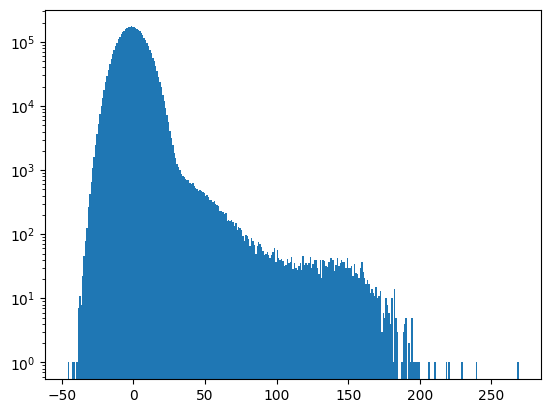

In [15]:
from histograms import make_histogram
master_dark = np.load('data/master_dark.npy')
img8 = np.load('data/images/image8.npy')

img8 -= master_dark

bin_centres, hist_data = make_histogram(img8, -1)

plt.bar(bin_centres, hist_data, width=bin_centres[1]-bin_centres[0])
plt.yscale('log')

In [16]:
from improved_spc import locate_primary_threshold, get_thresholded_hits

primary_threshold = locate_primary_threshold(img8, 2)
primary_threshold

77.50212226739738

### Log book note

At this point, I changed a line in `get_adjusted_primary_hit_values` from

    final_hit_values[i] = np.sum(secondary_neighbours.flatten()) + img[loc]

to

    final_hit_values[i] = np.sum(img[
            max(loc[0] - 1, 0) : min(loc[0] + 2, secondary_hits.shape[0]),
            max(loc[1] - 1, 0) : min(loc[1] + 2, secondary_hits.shape[1]),
        ]) + img[loc]

This sums the 3x3 around a pixel, rather than just the secondary thresholded ones. The secondary thresholded ones in this area are still recorded, so that thay are not treated as their own hit.


In [17]:
from improved_spc import get_img_hit_data

img8_hits = get_img_hit_data(img8, 2,2)

bin_centres, hist_data = make_histogram(img8_hits, -1)

plt.plot(bin_centres, hist_data, label="2,2")
plt.plot(*make_histogram(get_img_hit_data(img8, 2, 1), -1), label="2,1", color='r', alpha=0.5)
plt.plot(*make_histogram(get_img_hit_data(img8, 2, 3), -1), label="2,3", color='g')
plt.legend()
plt.xlim(0,450)
plt.ylim(0,300)
plt.xticks(np.arange(0, 450, 50))
plt.show()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\jwbar\OneDrive\University\B8\code\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\jwbar\AppData\Local\Temp\ipykernel_13300\3927477637.py", line 3, in <module>
    img8_hits = get_img_hit_data(img8, 2,2)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jwbar\OneDrive\University\B8\code\improved_spc.py", line 252, in get_img_hit_data
    secondaries = get_secondary_hit_values_and_locs(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jwbar\OneDrive\University\B8\code\improved_spc.py", line 210, in get_secondary_hit_values_and_locs
    hits = locate_hits(secondary_hits, used_secondaries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jwbar\OneDrive\University\B8\code\hit_detection.py", line -1, in locate_hits
KeyboardInterrupt

During handling of the above exception, another ex

In [ ]:
from improved_spc import locate_primary_threshold, locate_secondary_threshold

print(f"2,2: {locate_primary_threshold(img8[:, :1200], 2), locate_secondary_threshold(img8, 2)}")
print(f"2,3: {locate_primary_threshold(img8[:, :1200], 2), locate_secondary_threshold(img8, 3)}")

2,2: (93.77174395416844, 18.11994733239181)
2,3: (93.77174395416844, 27.68724486950194)


If the secondary sigma threshold goes too much below 2, we get dominated by noise. Going up to 3 loses the initial peak (although not sure if this is physical atm) so I've settled on 2.

Seems to be much less sensitive on the primary threshold.

Need to make sure that thresholds are consistent across the code, since they seem to modify peak locations slightly.





Let's try fitting a double gaussian to this. Opted to use 3 for the secondary sigma threshold, since I reckon the first peak is noise

(array([119.07269416,  88.24206126,  21.85141139,  22.69517039,
        263.78840672,  53.46694451]),
 array([0.88286096, 0.19719962, 0.21959909, 0.55016277, 1.49552465,
        1.5219923 ]))

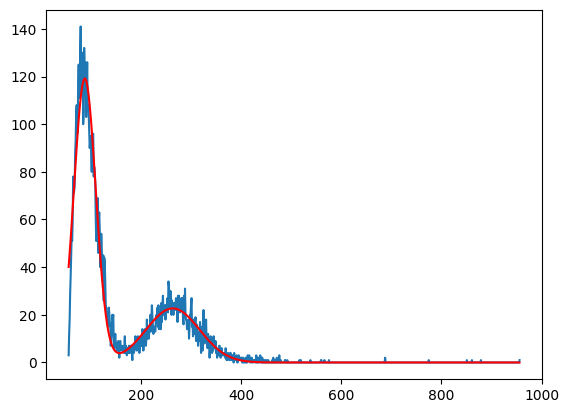

In [ ]:
from improved_spc import get_img_hit_data
from histograms import make_histogram
from scipy.optimize import curve_fit

def double_gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
    return a1*np.exp(-0.5*((x-mu1)/sigma1)**2) + a2*np.exp(-0.5*((x-mu2)/sigma2)**2)

img8_hits = get_img_hit_data(img8, 2,3)

bin_centres, hist_data = make_histogram(img8_hits, -1)

po = [150, 100, 20, 25, 250, 40]

popt, pcov = curve_fit(double_gaussian, bin_centres, hist_data, p0=po)

plt.plot(bin_centres, hist_data)
plt.plot(bin_centres, double_gaussian(bin_centres, *popt), color="r")

popt, np.sqrt(np.diag(pcov))



## Peak sizes

At this point, I did some basic Posson statistics, and found that the first peak should be ~100 times larger than the second, so it looks like the thresholds are off. Trying new ones:

In [7]:
from improved_spc import get_img_hit_data
from histograms import make_histogram
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

master_dark = np.load('data/master_dark.npy')
img8 = np.load('data/images/image8.npy')

img8 -= master_dark

primary_sigma = 0
secondary_sigma = 2.5

img8_hits = get_img_hit_data(img8, primary_sigma, secondary_sigma)

bin_centres, hist_data = make_histogram(img8_hits, -1)

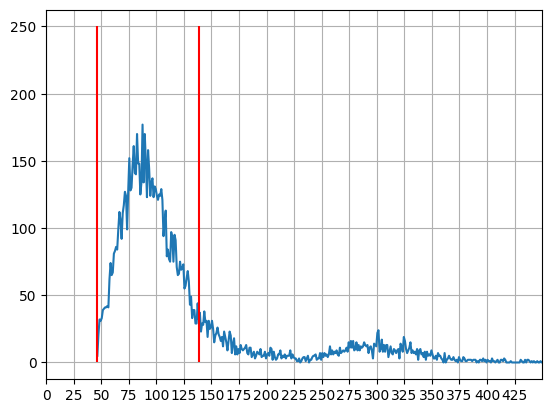

In [8]:
from improved_spc import locate_primary_threshold, locate_secondary_threshold
plt.plot(bin_centres, hist_data)
plt.xlim(0,450)
plt.xticks(np.arange(0, 450, 25))
plt.grid()

primary_threshold = locate_primary_threshold(img8[:, :1200], primary_sigma)
secondary_threshold = locate_secondary_threshold(img8, secondary_sigma)
plt.vlines(primary_threshold, 0, 250, color="r")
plt.vlines(2*secondary_threshold, 0, 250, color='r')



Fitting a double gaussian to this is hard, since the first peak is so much larger, and the function tends to converge both peaks onto it. So, instead, we fit to two subsets of the data

(array([4689.49271741,   25.9360641 ,   10.00473878]),
 array([111.77613436,   0.4246054 ,   0.44241428]),
 array([106.58171408, 184.73080343,  58.37923507]),
 array([0.62234026, 0.5236964 , 0.57052122]))

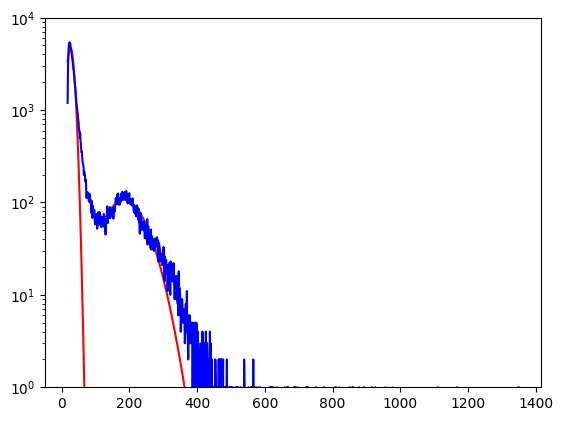

In [13]:
first_peak_indices = np.where(bin_centres < 125)
second_peak_indices = np.where(bin_centres > 125)

first_peak_data = hist_data[first_peak_indices]
second_peak_data = hist_data[second_peak_indices]
first_peak_x = bin_centres[first_peak_indices]
second_peak_x = bin_centres[second_peak_indices]

from scipy.optimize import curve_fit
from histograms import gaussian_model

popt1, pcov1 = curve_fit(gaussian_model, first_peak_x, first_peak_data, p0 = [5000, 25, 15])
popt2, pcov2 = curve_fit(gaussian_model, second_peak_x, second_peak_data, p0 = [100, 180, 40])

plt.plot(first_peak_x, gaussian_model(first_peak_x, *popt1), color="r")
plt.plot(second_peak_x, gaussian_model(second_peak_x, *popt2), color="r")
plt.plot(bin_centres, hist_data, color="b")
plt.yscale("log")
plt.ylim(1,1e4)

popt1, np.sqrt(np.diag(pcov1)), popt2, np.sqrt(np.diag(pcov2))

## Classifying hits

Given 2 distributions $N_1$ and $N_2$, we write (see [here](https://math.stackexchange.com/questions/825455/probability-that-a-sample-comes-from-one-of-two-distributions)):


$$\frac{P(N_1)}{P(N_2)} = \frac{a_1 e^{\frac{-(x-\mu_1)^2}{2\sigma_1^2}}}{a_2 e^{\frac{-(x-\mu_2)^2}{2\sigma_2^2}}}$$


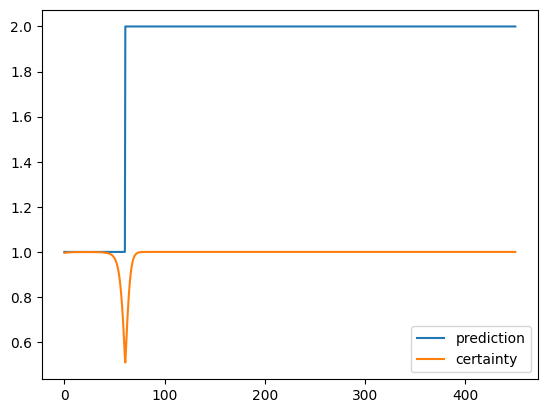

In [16]:
import matplotlib.pyplot as plt
class HitClassifier(object):

    def __init__(self, a1, mu1, sigma1, a2, mu2, sigma2):
        self.a1 = a1
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.a2 = a2
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.p1 = lambda x: a1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
        self.p2 = lambda x: a2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)

    def classify(self, x):
        p1 = self.p1(x)
        p2 = self.p2(x)
        if p1 > p2:
            # 1 photon
            return np.array([1, p1 / (p1 + p2)])
        else:
            return np.array([2, p2 / (p1 + p2)])
    
test_x = np.linspace(0, 450, 1000)
hc = HitClassifier(*popt1, *popt2)

predictions = np.array([hc.classify(x) for x in test_x])

plt.plot(test_x, predictions[:, 0], label="prediction")
plt.plot(test_x, predictions[:, 1], label = "certainty")
plt.legend()

# Task for tomorrow
- Go through image
- For every hit, get a central location
- Sum up values as required, and classify it as a single or double
- Maybe have another case for pixels that have too high a value (could check against $p_2/a_2$ or something)

## Old Classifier

In [8]:
from improved_spc import get_img_hit_data, locate_primary_threshold, locate_secondary_threshold
from histograms import make_histogram
from scipy.optimize import curve_fit
from histograms import make_histogram, gaussian_model
import numpy as np
import matplotlib.pyplot as plt

# Load the master dark and the image
master_dark = np.load("data/master_dark.npy")
img8 = np.load("data/images/image8.npy")

# Subtract the master dark from the image
img8 -= master_dark
# Fit a double Gaussian to the histogram of the hits to get single and double hits
from improved_spc import get_img_hit_data
from histograms import make_histogram
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt


primary_sigma = 0
secondary_sigma = 2.5

img8_hits = get_img_hit_data(img8, primary_sigma, secondary_sigma)

hit_bin_centres, hit_hist_data = make_histogram(img8_hits, -1)

"""def double_gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
    return a1*np.exp(-0.5*((x-mu1)/sigma1)**2) + a2*np.exp(-0.5*((x-mu2)/sigma2)**2)

p0 = [100, 100, 20, 10, 300, 40]
bounds = ([0, 0, 0, 0, 270, 0], [np.inf, np.inf, np.inf, np.inf, 330, np.inf])
popt, pcov = curve_fit(double_gaussian, hit_bin_centres, hit_hist_data, p0=p0, bounds=bounds)
"""# locate the peaks
first_peak_indices = np.where(hit_bin_centres < 225)
second_peak_indices = np.where(hit_bin_centres > 225)

first_peak_data = hit_hist_data[first_peak_indices]
second_peak_data = hit_hist_data[second_peak_indices]
first_peak_x = hit_bin_centres[first_peak_indices]
second_peak_x = hit_bin_centres[second_peak_indices]

popt1, pcov1 = curve_fit(gaussian_model, first_peak_x, first_peak_data, p0 = [150, 100, 15])
popt2, pcov2 = curve_fit(gaussian_model, second_peak_x, second_peak_data, p0 = [15, 300, 40])

# get thresholds
primary_threshold = locate_primary_threshold(img8[:, :1200], primary_sigma)
secondary_threshold = locate_secondary_threshold(img8, secondary_sigma)


popt1, np.sqrt(np.diag(pcov1)), popt2, np.sqrt(np.diag(pcov2))


(array([142.57343887,  90.21657122,  26.5575525 ]),
 array([2.22016776, 0.48809206, 0.52770944]),
 array([ 12.04483296, 299.4597486 ,  39.0133411 ]),
 array([0.1771383 , 0.66560587, 0.69851337]))

(0.0, 400.0)

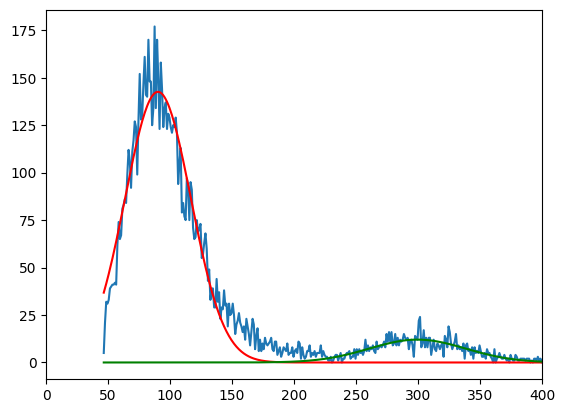

In [9]:

plt.plot(hit_bin_centres, hit_hist_data)
plt.plot(hit_bin_centres, gaussian_model(hit_bin_centres, *popt1), color="r")
plt.plot(hit_bin_centres, gaussian_model(hit_bin_centres, *popt2), color="g")
plt.xlim(0,400)

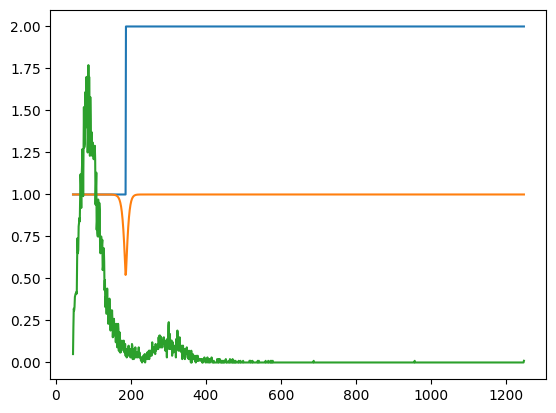

In [11]:
class HitClassifier(object):

    def __init__(self, a1, mu1, sigma1, a2, mu2, sigma2):
        self.a1 = a1
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.a2 = a2
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.p1 = lambda x: a1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
        self.p2 = lambda x: a2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)

    def classify(self, x):
        p1 = self.p1(x)
        p2 = self.p2(x)
        if p1 > p2:
            # 1 photon
            return np.array([1, p1 / (p1 + p2)])
        else:
            return np.array([2, p2 / (p1 + p2)])
        
hc = HitClassifier(*popt1, *popt2)
plt.plot(hit_bin_centres, [hc.classify(x)[0] for x in hit_bin_centres], label="prediction")
plt.plot(hit_bin_centres, [hc.classify(x)[1] for x in hit_bin_centres], label="certainty")
plt.plot(hit_bin_centres, hit_hist_data/100, label="histogram")

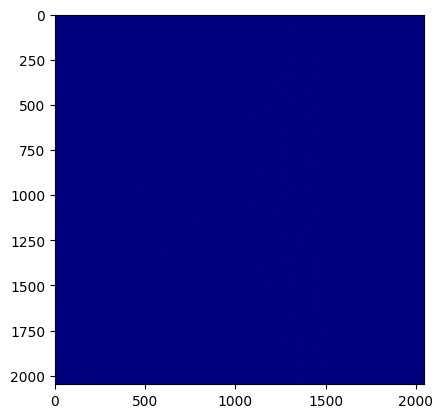

((1427, 2), (9444, 2))

In [13]:
from improved_spc import get_adjusted_primary_hit_values, get_primary_hit_locations, get_secondary_hit_values_and_locs, get_thresholded_hits
primary_threshold = locate_primary_threshold(img8[:, :1200], primary_sigma)
secondary_threshold = locate_secondary_threshold(img8, secondary_sigma)

# get all the hits values and their locations
primary_hit_values, used_secondaries = get_adjusted_primary_hit_values(
    img8, primary_threshold, secondary_threshold
)
primary_hit_locations = get_primary_hit_locations(
    get_thresholded_hits(img8, primary_threshold, None)
)

secondary_hit_values, secondary_hit_locations = get_secondary_hit_values_and_locs(img8, primary_threshold, secondary_threshold, used_secondaries)

hit_values = np.concatenate((primary_hit_values, secondary_hit_values))
hit_locations = np.concatenate((primary_hit_locations, secondary_hit_locations))

hit_classifier = HitClassifier(*popt1, *popt2)

predictions = np.array([hit_classifier.classify(x) for x in hit_values])
hit_image = np.zeros_like(img8)

for (hit, loc) in zip(predictions, hit_locations):
    hit_image[tuple(loc.astype(np.int64))] = hit[0]

plt.imshow(hit_image, cmap="jet")
plt.show()

predictions[predictions[:, 0] == 2].shape, predictions[predictions[:, 0] == 1].shape

(1, 10000.0)

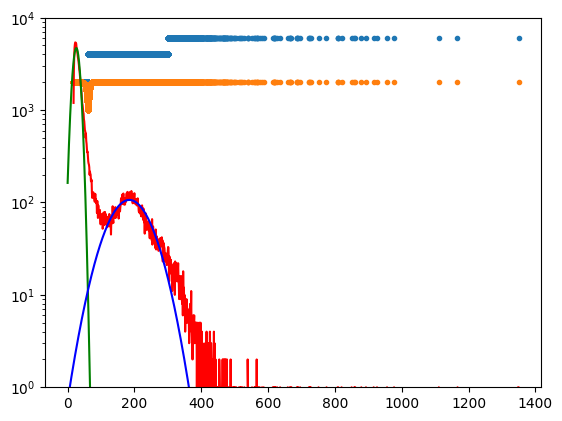

In [5]:

plt.scatter(hit_values, predictions[:, 0]*2000, label="prediction", marker=".")
plt.scatter(hit_values, predictions[:, 1]*2000, label="certainty", marker=".")
plt.plot(hit_bin_centres, hit_hist_data, color="r", label="distribution")
plt.plot(np.linspace(0, 450, 1000), hit_classifier.p1(np.linspace(0, 450, 1000)), color="g", label="single photon")
plt.plot(np.linspace(0, 450, 1000), hit_classifier.p2(np.linspace(0, 450, 1000)), color="b", label="double photon")
plt.yscale("log")
plt.ylim(1,1e4)

Above classifier is therefore not ideal, since devision boundary is not at minimum

## Improved Classifier
Let's use the minimum as a dividing point

In [16]:
from improved_spc import get_img_hit_data, locate_primary_threshold, locate_secondary_threshold
from histograms import make_histogram
from scipy.optimize import curve_fit
from histograms import make_histogram, gaussian_model
import numpy as np
import matplotlib.pyplot as plt

# Load the master dark and the image
master_dark = np.load("data/master_dark.npy")
img8 = np.load("data/images/image8.npy")

# Subtract the master dark from the image
img8 -= master_dark
# Fit a double Gaussian to the histogram of the hits to get single and double hits

primary_sigma = 0
secondary_sigma = 2.5

img8_hits = get_img_hit_data(img8, primary_sigma, secondary_sigma)

hit_bin_centres, hit_hist_data = make_histogram(img8_hits, -1)

# locate the peaks
"""first_peak_indices = np.where(hit_bin_centres < 125)
second_peak_indices = np.where(hit_bin_centres > 125)

first_peak_data = hit_hist_data[first_peak_indices]
second_peak_data = hit_hist_data[second_peak_indices]
first_peak_x = hit_bin_centres[first_peak_indices]
second_peak_x = hit_bin_centres[second_peak_indices]

popt1, pcov1 = curve_fit(gaussian_model, first_peak_x, first_peak_data, p0 = [5000, 25, 15])
popt2, pcov2 = curve_fit(gaussian_model, second_peak_x, second_peak_data, p0 = [100, 180, 40])
"""
# get thresholds
primary_threshold = locate_primary_threshold(img8[:, :1200], primary_sigma)
secondary_threshold = locate_secondary_threshold(img8, secondary_sigma)


30
46.500103993344425
0 2.5
138.31781351377927 22.90359610094687


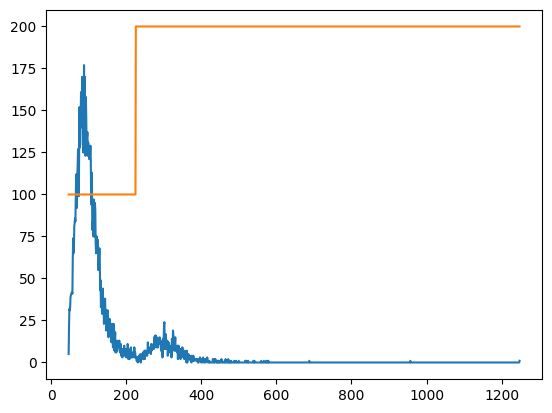

In [40]:
from improved_spc import (
    get_adjusted_primary_hit_values,
    get_primary_hit_locations,
    get_thresholded_hits,
    get_secondary_hit_values_and_locs,
)
%matplotlib inline

class HitClassifier:

    def __init__(self, bin_centres, hist_data):
        search_range = np.where(np.logical_and(bin_centres < 300,bin_centres > 200))
        print(np.argmin(hist_data[search_range]))
        self.boundary = bin_centres[np.argmin(bin_centres[search_range])]
        print(self.boundary)
        self.boundary = 225

    def classify(self, x):
        """p1 = self.p1(x)
        p2 = self.p2(x)
        if p1 > p2:
            # single photon
            return np.array([1, p1 / (p1 + p2)])
        elif x>self.mu2+2*self.sigma2:
            return np.array([3, 1])
        else:
            return np.array([2, p2 / (p1 + p2)])"""
        if x < self.boundary:
            return [1,1]
        else:
            return [2, 1]

HitClassifier(hit_bin_centres, hit_hist_data)
plt.plot(hit_bin_centres, hit_hist_data)
print(primary_sigma, secondary_sigma)
print(primary_threshold, secondary_threshold)
"""# get all the hits values and their locations
primary_hit_values, used_secondaries = get_adjusted_primary_hit_values(
    img8, primary_threshold, secondary_threshold
)
primary_hit_locations = get_primary_hit_locations(
    get_thresholded_hits(img8, primary_threshold, None)
)

secondary_hit_values, secondary_hit_locations = get_secondary_hit_values_and_locs(img8, primary_threshold, secondary_threshold, used_secondaries)

hit_values = np.concatenate((primary_hit_values, secondary_hit_values))
hit_locations = np.concatenate((primary_hit_locations, secondary_hit_locations))

hit_classifier = HitClassifier(*popt1, *popt2)

predictions = np.array([hit_classifier.classify(x) for x in hit_values])"""
sum(hit_hist_data[hit_bin_centres < 225]), sum(hit_hist_data[hit_bin_centres > 225])
classifications = np.array([1 if x < 225 else 2 for x in hit_bin_centres])

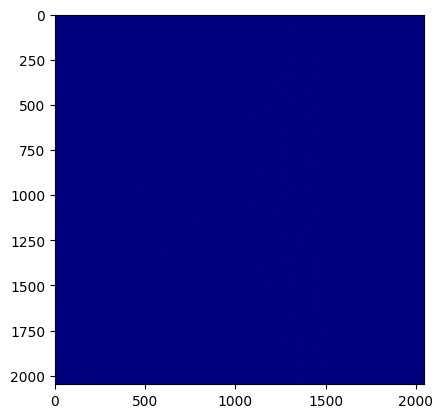

((1427, 2), (9444, 2))

In [29]:
%matplotlib inline
hit_image = np.zeros_like(img8)

for (hit, loc) in zip(predictions, hit_locations):
    hit_image[tuple(loc.astype(np.int64))] = hit[0]

plt.imshow(hit_image, cmap="jet")
plt.show()

predictions[predictions[:, 0] == 2].shape, predictions[predictions[:, 0] == 1].shape

In [42]:
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, linewidth=2, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect
%matplotlib qt
plt.imshow(img8, cmap="jet")
for (loc, classi) in zip(hit_locations, classifications):
    if classi == 2:
        highlight_cell(loc[1], loc[0], color="red")
    else:
        highlight_cell(loc[1], loc[0], color="black")

# Test

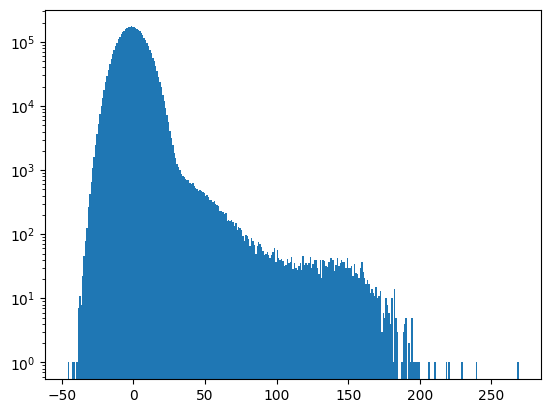

In [ ]:
img8 = np.load("data/images/image8.npy")
master_dark = np.load("data/master_dark.npy")

img8 -= master_dark

bin_centres, hist_data = make_histogram(img8, -1)

plt.bar(bin_centres, hist_data, width=bin_centres[1] - bin_centres[0])
plt.yscale("log")